In [30]:
%autoreload 2

In [44]:
from collections import defaultdict
import difflib
import gzip
import os
import pickle
import re
import sys
import time
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pactools.grid_search import GridSearchCVProgressBar
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.ast_utils import load_games_from_file, _extract_game_id, cached_load_and_parse_games_from_file
from src import ast_printer

In [32]:
import openai
openai.api_key = os.getenv('OPENAI_API_KEY')

In [43]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_5150/959906715.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='../dsl/dsl.ebnf' mode='r' encoding='UTF-8'>
  grammar = open('../dsl/dsl.ebnf').read()
/Users/guydavidson/projects/game-generation-modeling/src/ast_utils.py:54: ResourceWarning: unclosed file <_io.TextIOWrapper name='../dsl/interactive-beta.pddl' mode='r' encoding='UTF-8'>
  lines = open(path).readlines()


In [5]:
whitespace_pattern = re.compile(r'\s+')

def embed_text(text: str, model: str = 'text-embedding-ada-002'):
    text = whitespace_pattern.sub(' ', text)
    return openai.Embedding.create(input = [text], model=model)


def embed_multiple_texts(texts: typing.List[str], model: str = 'text-embedding-ada-002'):
    texts = [whitespace_pattern.sub(' ', t) for t in texts]
    return openai.Embedding.create(input = texts, model=model)


In [53]:
REGENERATE_EMBEDDINGS = False 

if REGENERATE_EMBEDDINGS:
    result = embed_multiple_texts(game_texts)
    # embeddings = np.array([result.data[i].embedding for i in range(len(result.data))])
    embeddings = torch.tensor([result.data[i].embedding for i in range(len(result.data))])
    torch.save(embeddings, '../data/interactive-beta-embeddings.pt', pickle_protocol=pickle.HIGHEST_PROTOCOL)

else:
    embeddings = torch.load('../data/interactive-beta-embeddings.pt')

In [54]:
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
REGROWN_GAMES_PER_ORIGINAL = int(len(regrown_game_texts) / len(game_texts))
embeddings_by_original_game = []

game_id_pattern = re.compile(r'([\d\w]+-\d+)-\d+')
regrown_game_texts = [game_id_pattern.sub(r'\1', text) for text in regrown_game_texts]

/Users/guydavidson/projects/game-generation-modeling/src/ast_utils.py:54: ResourceWarning: unclosed file <_io.TextIOWrapper name='../dsl/ast-real-regrowth-samples.pddl' mode='r' encoding='UTF-8'>
  lines = open(path).readlines()


In [57]:
REGENERATE_REGROWTH_EMBEDDINGS = False

if REGENERATE_REGROWTH_EMBEDDINGS:
    start_index = len(embeddings_by_original_game)

    for i in tqdm.tnrange(len(game_texts)):
        game_regrown_games = regrown_game_texts[i * REGROWN_GAMES_PER_ORIGINAL: (i + 1) * REGROWN_GAMES_PER_ORIGINAL]
        game_results = embed_multiple_texts(game_regrown_games)
        game_embeddings = torch.tensor([game_results.data[i].embedding for i in range(len(game_results.data))])
        embeddings_by_original_game.append(game_embeddings)
        time.sleep(5)

    regrowth_embeddings = torch.stack(embeddings_by_original_game)
    print(regrowth_embeddings.shape)
    torch.save(regrowth_embeddings, '../data/ast-real-regrowth-samples-embeddings.pt', pickle_protocol=pickle.HIGHEST_PROTOCOL)

else:
    regrowth_embeddings = torch.load('../data/ast-real-regrowth-samples-embeddings.pt')

## Let's see what the space of these embeddings looks like

In [58]:
all_embeddings = torch.cat([embeddings, regrowth_embeddings.reshape(-1, regrowth_embeddings.shape[-1])], dim=0)
all_embeddings.shape

torch.Size([6370, 1536])

In [59]:
pca = PCA(n_components=100)
pca.fit(all_embeddings.numpy())

PCA(n_components=100)

0.037240762

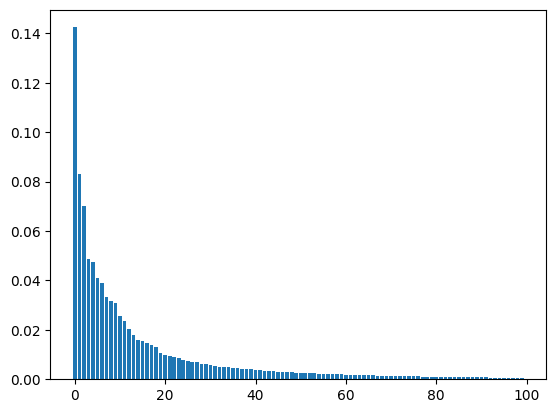

In [60]:
n_components = 100
plt.bar(np.arange(n_components), pca.explained_variance_ratio_[:n_components])
pca.explained_variance_ratio_[64:].sum()

In [61]:
PCA_N_DIM = 64
SEED = 33
PCA_KWARGS = dict(random_state=SEED)
TSNE_KAWRGS = dict(init='pca', learning_rate='auto', random_state=SEED)

def pca_and_tsne(data: np.ndarray, pca_n_dim: int = PCA_N_DIM, 
    pca_kwargs: typing.Optional[typing.Dict] = None, tsne_kwargs: typing.Optional[typing.Dict] = None):

    if pca_kwargs is None:
        pca_kwargs = PCA_KWARGS
    else:
        temp_kwargs = PCA_KWARGS.copy()
        temp_kwrags.update(pca_kwargs)
        pca_kwargs = temp_kwargs

    if tsne_kwargs is None:
        tsne_kwargs = TSNE_KAWRGS

    else:
        temp_kwrags = TSNE_KAWRGS.copy()
        temp_kwrags.update(tsne_kwargs)
        tsne_kwargs = temp_kwrags

    if data.ndim > 2:
        data = data.reshape(-1, data.shape[-1])

    pca = PCA(n_components=pca_n_dim, **pca_kwargs)
    data_pca = pca.fit_transform(data)
    tsne = TSNE(n_components=2, **tsne_kwargs)
    data_tsne = tsne.fit_transform(data_pca)

    return data_tsne

In [62]:
tsne_embedded_data = pca_and_tsne(all_embeddings.numpy())
tsne_embedded_data.shape

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(6370, 2)

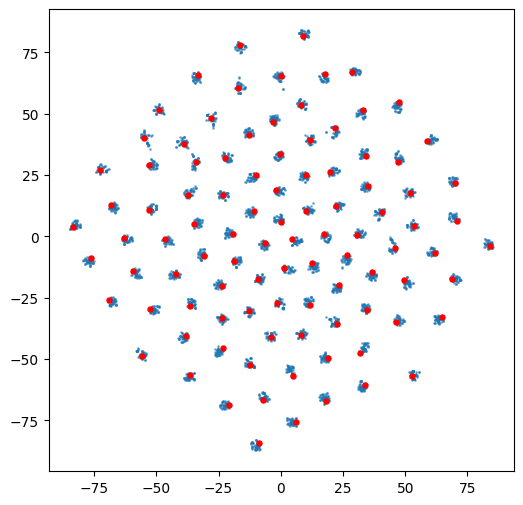

In [63]:
n_games = len(game_texts)
plt.figure(figsize=(6, 6))
plt.scatter(tsne_embedded_data[n_games:, 0], tsne_embedded_data[n_games:, 1], s=1, alpha=0.5)
plt.scatter(tsne_embedded_data[:n_games, 0], tsne_embedded_data[:n_games, 1], s=13, c='red')


## Let's see what happens if we try to fit a fitness model based on these embeddings?

In [64]:
embeddings_for_fitness = torch.cat([embeddings.unsqueeze(1), regrowth_embeddings], dim=1)
embeddings_for_fitness.shape

torch.Size([98, 65, 1536])

In [96]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
]

model_kwargs = dict(output_activation=nn.ReLU())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv = utils.model_fitting_experiment(embeddings_for_fitness, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


In [ ]:
cv, (train_tensor, test_tensor), test_results = cv
print(test_results)

{'ecdf': -0.0085, 'game_rank': 1.0}


In [79]:
cv_df = pd.concat([
    pd.DataFrame(cv.cv_results_["params"]), 
    pd.DataFrame(cv.cv_results_["mean_test_overall_ecdf"], columns=['ecdf_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_overall_ecdf"], columns=['ecdf_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_overall_ecdf"], columns=['ecdf_rank']),
    pd.DataFrame(cv.cv_results_["mean_test_single_game_rank"], columns=['game_rank_mean']), 
    pd.DataFrame(cv.cv_results_["std_test_single_game_rank"], columns=['game_rank_std']), 
    pd.DataFrame(cv.cv_results_["rank_test_single_game_rank"], columns=['game_rank_rank']),
],axis=1)

cv_df.sort_values(by='ecdf_rank').head(10)

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
730,8,8,<function fitness_hinge_loss at 0x16325fd00>,0.03,4,1536,1.00,-0.008186,0.000016,1,1.0,0.0,1
876,8,32,<function fitness_hinge_loss at 0x16325fd00>,0.01,8,1536,0.00,-0.008186,0.000016,1,1.0,0.0,1
879,8,32,<function fitness_hinge_loss at 0x16325fd00>,0.01,8,1536,2.00,-0.008186,0.000016,1,1.0,0.0,1
897,8,64,<function fitness_hinge_loss at 0x16325fd00>,0.10,1,1536,0.25,-0.008186,0.000016,1,1.0,0.0,1
95,2,8,<function fitness_hinge_loss at 0x16325fd00>,0.03,8,1536,2.00,-0.008186,0.000016,1,1.0,0.0,1
94,2,8,<function fitness_hinge_loss at 0x16325fd00>,0.03,8,1536,1.00,-0.008186,0.000016,1,1.0,0.0,1
906,8,64,<function fitness_hinge_loss at 0x16325fd00>,0.10,4,1536,1.00,-0.008186,0.000016,1,1.0,0.0,1
91,2,8,<function fitness_hinge_loss at 0x16325fd00>,0.03,4,1536,2.00,-0.008186,0.000016,1,1.0,0.0,1
237,2,32,<function fitness_hinge_loss at 0x16325fd00>,0.01,8,1536,0.25,-0.008186,0.000016,1,1.0,0.0,1
227,2,32,<function fitness_hinge_loss at 0x16325fd00>,0.01,1,1536,2.00,-0.008186,0.000016,1,1.0,0.0,1


In [80]:
cv_df.sort_values(by='game_rank_rank').head(10)

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
0,2,4,<function fitness_hinge_loss at 0x16325fd00>,0.10,1,1536,0.00,-0.011278,0.003368,762,1.0,0.0,1
780,8,16,<function fitness_hinge_loss at 0x16325fd00>,0.10,8,1536,0.00,-0.008210,0.000044,429,1.0,0.0,1
781,8,16,<function fitness_hinge_loss at 0x16325fd00>,0.10,8,1536,0.25,-0.008186,0.000016,61,1.0,0.0,1
782,8,16,<function fitness_hinge_loss at 0x16325fd00>,0.10,8,1536,1.00,-0.008186,0.000016,61,1.0,0.0,1
783,8,16,<function fitness_hinge_loss at 0x16325fd00>,0.10,8,1536,2.00,-0.008186,0.000016,61,1.0,0.0,1
786,8,16,<function fitness_hinge_loss at 0x16325fd00>,0.03,1,1536,1.00,-0.051370,0.028947,1087,1.0,0.0,1
787,8,16,<function fitness_hinge_loss at 0x16325fd00>,0.03,1,1536,2.00,-0.008222,0.000067,447,1.0,0.0,1
788,8,16,<function fitness_hinge_loss at 0x16325fd00>,0.03,2,1536,0.00,-0.052475,0.023741,1092,1.0,0.0,1
789,8,16,<function fitness_hinge_loss at 0x16325fd00>,0.03,2,1536,0.25,-0.038735,0.020569,1019,1.0,0.0,1
790,8,16,<function fitness_hinge_loss at 0x16325fd00>,0.03,2,1536,1.00,-0.008186,0.000016,61,1.0,0.0,1


In [95]:
cv_df.groupby('fitness__weight_decay').ecdf_mean.mean()

fitness__weight_decay
0.00   -0.030315
0.25   -0.028234
1.00   -0.022054
2.00   -0.016997
Name: ecdf_mean, dtype: float64

In [84]:
cv.best_estimator_.fit(embeddings_for_fitness)
cv_fitness_model = cv.best_estimator_

output_path = '../models/cv_fitness_model_2023_01_16_from_embeddings.pkl.gz'
original_output_path = output_path[:]
i = 0
while os.path.exists(output_path):
    output_path = original_output_path + f'_{i}'
    i += 1

with gzip.open(output_path, 'wb') as f:
    pickle.dump(cv_fitness_model, f, protocol=pickle.HIGHEST_PROTOCOL)



In [81]:
# cv_fitness_model = pickle.load(gzip.open('../models/cv_fitness_model_2023_01_16_from_embeddings.pkl.gz', 'rb'))
cv_fitness_model = cv.best_estimator_

In [82]:
train_positive_scores = cv.best_estimator_.transform(train_tensor[:, 0, :]).detach().squeeze().numpy()
train_negative_scores = cv.best_estimator_.transform(train_tensor[:, 1:, :]).detach().squeeze().numpy()

test_positive_scores = cv.best_estimator_.transform(test_tensor[:, 0, :]).detach().squeeze().numpy()
test_negative_scores = cv.best_estimator_.transform(test_tensor[:, 1:, :]).detach().squeeze().numpy()

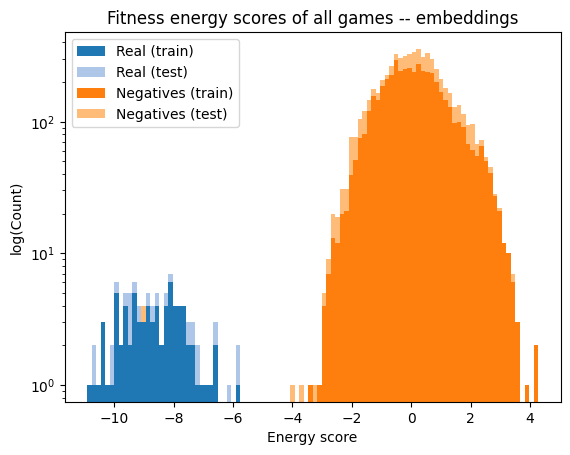

In [83]:
cm = plt.get_cmap('tab20')
plt.hist([train_positive_scores, test_positive_scores, train_negative_scores.flatten(), test_negative_scores.flatten()], 
    stacked=True, bins=100, label=['Real (train)', 'Real (test)', 'Negatives (train)', 'Negatives (test)'],
    color=cm.colors[:4])
plt.title('Fitness energy scores of all games -- embeddings')
plt.xlabel('Energy score')
plt.ylabel('log(Count)')
plt.semilogy()
plt.legend(loc='best')



5.1561572e-05 0.011656938 2.6330941e-05


Text(0, 0.5, 'Count')

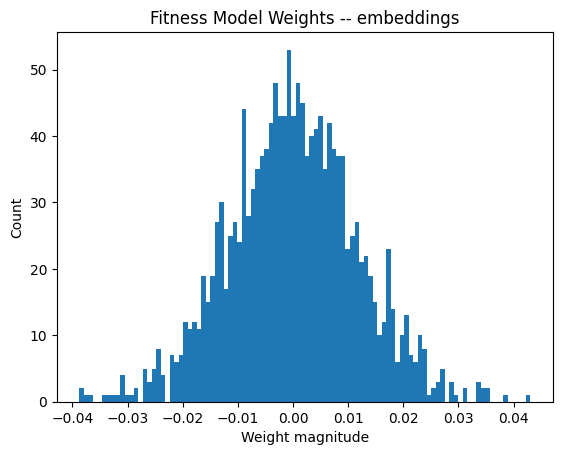

In [74]:
weights = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().numpy().squeeze()
bias = cv.best_estimator_.named_steps['fitness'].model.fc1.bias.data.detach().numpy().squeeze()
print(weights.mean(), weights.std(), bias)

plt.hist(weights, bins=100)
plt.title('Fitness Model Weights -- embeddings')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')

## What if I concatante my features and the embeddings?

In [ ]:
fitness_features_tensor = torch.load('../data/interactive-beta-and-regrowth-fitness-features-2023-01-09.pt')
print(fitness_features_tensor.shape, embeddings_for_fitness.shape)

features_and_embeddings = torch.cat([fitness_features_tensor, embeddings_for_fitness], dim=-1)
features_and_embeddings.shape

In [ ]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
]

model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict()
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv_with_features = model_fitting_experiment(features_and_embeddings, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)


In [ ]:
cv_with_features_df = pd.concat([
    pd.DataFrame(cv_with_features.cv_results_["params"]), 
    pd.DataFrame(cv_with_features.cv_results_["mean_test_overall_ecdf"], columns=['ecdf_mean']), 
    pd.DataFrame(cv_with_features.cv_results_["std_test_overall_ecdf"], columns=['ecdf_std']), 
    pd.DataFrame(cv_with_features.cv_results_["rank_test_overall_ecdf"], columns=['ecdf_rank']),
    pd.DataFrame(cv_with_features.cv_results_["mean_test_single_game_rank"], columns=['game_rank_mean']), 
    pd.DataFrame(cv_with_features.cv_results_["std_test_single_game_rank"], columns=['game_rank_std']), 
    pd.DataFrame(cv_with_features.cv_results_["rank_test_single_game_rank"], columns=['game_rank_rank']),
],axis=1)

cv_with_features_df.sort_values(by='ecdf_rank').head(10)

In [ ]:
cv_with_features_df.sort_values(by='game_rank_rank').head(10)

In [ ]:
cv_with_features.best_estimator_.fit(features_and_embeddings)
cv_fitness_model_with_features = cv_with_features.best_estimator_

real_scores = cv_fitness_model_with_features.transform(features_and_embeddings[:, 0, :]).detach().squeeze().numpy()
negative_scores = cv_fitness_model_with_features.transform(features_and_embeddings[:, 1:, :]).detach().squeeze().numpy()
real_scores.mean(), real_scores.std()

In [ ]:
plt.hist([real_scores, negative_scores.flatten()], stacked=True, bins=100,
    label=['Real games', 'Negatives'])
plt.title('Fitness energy scores of all games -- embeddings + features')
plt.xlabel('Energy score')
plt.ylabel('log(Count)')
plt.semilogy()
plt.legend(loc='best')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
tts = train_test_split(embeddings_for_fitness, train_size=utils.DEFAULT_TRAINING_PROP)

In [ ]:
[t.shape for t in tts]